4G5 Coursework Computer Project: rubber elasticity
====

<!--<img src="./isoprene.png" height=200>-->
<img src="./polyisoprene.png" height=200>

In this project, you are going to investigate the elastic properties of rubber. There are many different types of rubber, both synthetic and
natural, the latter mostly derived from the fluids of the [rubber tree](https://en.wikipedia.org/wiki/Hevea_brasiliensis). All of them have a
common structure: extremely long chains of flexible polymers. Different materials vary in the composition of the polymers, whether and how
cross-linked they are. In this project, we are going to consider the polyisoprene molecule, which is the major constitutent of 
natural rubber. Isoprene is a simple hydrocarbon, a naturally very abundant molecule, even humans produce some! To keep things simple, you
will study only a single polymer chain, and to keep the computational effort low, only a short one. This is already sufficient to display
the main phenomenology of elasticity. 

The main objective of the project is to demonstrate the linear restoring force as a function of displacement for the polyisoprene molecule. 
This will be accomplished by _constrained_ molecular dynamics at constant temperature, in which the two ends of the molecule will be kept at a 
given distance apart, and the molecular motion simulated as it explores the allowable conformations. After sufficient 
data is accumulated, the average force on the end points is recorded, and a new, larger distance is set, repeating the previous procedure. You will
need to use error analysis to determine how long a simulation to do at a fixed displacement before moving on to the next one. 

__Your report__ should contain the measured average restoring force as a function of displacement, with appropriate error bars, and brief commentary on what
you have found. Also consider the average internal energy of molecule (also as a function of displacement), and comment on its relationship to the 
restoring force. 

Notes: 

- If you find that you are spending more than 6 hours on the coursework, seek help. This does _not_ include the runtime of the simulation that you use to gather 
your final data (after you've done shorter exploratory work), it is recommended that you run it overnight. Always make an estimate on how
long a given run will take, never start a simulation for which you have no idea when it will finish!
- Don't forget that the coursework is marked anonymously, so make sure that you include a [coursework cover sheet](http://teaching.eng.cam.ac.uk/node/4171) as the
first page of your report that you upload to Moodle. 
- The marking will be focused on your understanding of the modelling and data analysis, rather than on programming. If you are stuck, seek help.


Preliminaries
----

In [1]:
# Pre - Preliminaries
#!pip install numpy # who hasn't got numpy installed?
!pip install ase
!pip install torchani

In [23]:
#
# import basic atomistic simulation modules
#
import numpy as np
import ase
from ase.build import bulk
from ase.data.pubchem import pubchem_atoms_search
from ase.visualize import view
import matplotlib.pyplot as plt
import pandas as pd 
from statsmodels.tsa.stattools import acf


In [3]:
# get the structure of isoprene
isoprene = pubchem_atoms_search(smiles="CC=C(C)C")
view(isoprene, viewer='x3d')

In [4]:
# import an energy model 
import sys
sys.path.insert(0, "ANI")
import ani

/Users/mac/anaconda3/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


In [5]:
isoprene.calc = ani.calculator
isoprene.get_potential_energy()

-5346.541799350911

In [6]:
#
# now import the modules we need to run molecular dynamics
#
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory


In [7]:
# this initialises the velocities by drawing from the appropriate distribution at T=300K
MaxwellBoltzmannDistribution(isoprene, temperature_K=300) 

# We now create a molecular dynamics object that can be used to run Langevin dynamics
# the parameters after the structure are the time step, the temperature, and the friction constant (in units of picoseconds)
dynamics = Langevin(isoprene, temperature_K=300, timestep=0.5*units.fs, friction=0.01) 


# While the dynamics is running, we want to collect some data! This is achieved by creating a function to the dynamics object
# which gets called after some number of steps, and it can report to us what is happenning to the molecule, record its trajectory, etc. 
xyzfile = open('isoprene.xyz', 'w') # the file we are going to record the structures to, the visualiser application "Ovito" can read such XYZ files. 
def report():
    print("Time: {:.3f} fs  |  Potential Energy: {:.3f} eV  |  Kinetic Energy: {:.3f} K".format(dynamics.get_time()/units.fs, isoprene.get_potential_energy(),
        isoprene.get_kinetic_energy()/(len(isoprene)*(3.0/2.0)*units.kB)))
    ase.io.write(xyzfile, isoprene, format="extxyz")

# notice how we print the kinetic energy in units of Kelvin, but it is not the thermodynamic temperature (which is kept constant)

dynamics.attach(report, interval=1) # the interval argument specifies how many steps of dynamics are run between each call to record the trajectory
dynamics.run(100)
xyzfile.close()
del dynamics

# After execution, you will see a new file called "isoprene.xyz". You can look at it, and see what it records. Download it, and view the molecular
# motion using the "Ovito" application. 

Time: 0.000 fs  |  Potential Energy: -5346.542 eV  |  Kinetic Energy: 314.506 K
Time: 0.500 fs  |  Potential Energy: -5346.522 eV  |  Kinetic Energy: 308.166 K
Time: 1.000 fs  |  Potential Energy: -5346.467 eV  |  Kinetic Energy: 278.664 K
Time: 1.500 fs  |  Potential Energy: -5346.399 eV  |  Kinetic Energy: 244.168 K
Time: 2.000 fs  |  Potential Energy: -5346.346 eV  |  Kinetic Energy: 218.852 K
Time: 2.500 fs  |  Potential Energy: -5346.322 eV  |  Kinetic Energy: 206.568 K
Time: 3.000 fs  |  Potential Energy: -5346.330 eV  |  Kinetic Energy: 210.642 K
Time: 3.500 fs  |  Potential Energy: -5346.362 eV  |  Kinetic Energy: 224.193 K
Time: 4.000 fs  |  Potential Energy: -5346.393 eV  |  Kinetic Energy: 243.970 K
Time: 4.500 fs  |  Potential Energy: -5346.400 eV  |  Kinetic Energy: 250.203 K
Time: 5.000 fs  |  Potential Energy: -5346.382 eV  |  Kinetic Energy: 241.421 K
Time: 5.500 fs  |  Potential Energy: -5346.341 eV  |  Kinetic Energy: 222.339 K
Time: 6.000 fs  |  Potential Energy: -53

In [9]:
# Ovito also helps you to select atoms by dragging the "Particles/GLobal Attributes" tab upwards a bit,
# and selecting the little target crosshairs on the left, then clicking on individual atoms. The "ParticleIndex" variable tells you the order
# of the atoms in the file and the ASE atoms object. 

# For example, particle indices 8 and 13 correspond to two H atoms on opposite ends of the isoprene molecule, and we can get their distance:
dr = (isoprene.get_positions()[8,:]-isoprene.get_positions()[13,:])
print("relative displacement vector:", dr)
r = np.linalg.norm(dr)
print("distance: ", r)
dru = dr/np.linalg.norm(dr)
print("unit vector in the same direction:", dru)

relative displacement vector: [ 5.04964637 -0.24955108 -1.95143899]
distance:  5.4193466688106655
unit vector in the same direction: [ 0.93178139 -0.04604819 -0.3600875 ]


Exercise 1 : dynamics and autocorrelation
----

Run molecular dynamics of isoprene, and record the distance between atoms 8 and 13 (two hydrogens) every 10 steps. Plot the time evolution
of this distance, and calculate the autocorrelation function. Run the trajectory long enough that you sample the methyl groups rotating around
the C-C bond. Repeat the exercise at higher temperature (e.g. 500 K), what happens to the autocorrelation function ? 

Note: you can calculate the autocorrelation yourself, or learn to use the `acf` function in  `statsmodels.tsa.stattools`

In [28]:
# --------------------------------- Initial Notes ---------------------------------
'''

We need to:
1. run molecular dynamics of isoprene
2. record the distance between atoms 8 and 13 every 10 steps 
3. plot the time evolution of this distance
4. calculate the autocorrelation function (on what)

Initial Notes

We have the code which currently:
- initialises velocity of molecules and particles
- creates the molecular dynamics object
- have a 'report' function which gets called after a certain number of steps to report
- dynamics.run(100): runs 100 steps of our molecular simulation
- dynamics.attach(report, interval = n): reports every n steps of our simulation
- .get_positions()[k,:] gets the position (in 3-dimensions) of our atoms in our molecules

- we need to investigate the acf function 


- first steps - lets run the dynamics and report every 10 time steps the distance between the two atoms

'''
# --------------------------------- Initial Code ---------------------------------


# this initialises the velocities by drawing from the appropriate distribution at T=300K
MaxwellBoltzmannDistribution(isoprene, temperature_K=300) 

# We now create a molecular dynamics object that can be used to run Langevin dynamics
# the parameters after the structure are the time step, the temperature, and the friction constant (in units of picoseconds)
dynamics = Langevin(isoprene, temperature_K=300, timestep=0.5*units.fs, friction=0.01) 

xyz_file = open('exercise_1_300K.xyz', 'w')

distance_df_300 = []
full_distance_df_300 = []

def report():

    pos_8 = isoprene.get_positions()[8,:] # retrieve position 8
    pos_13 = isoprene.get_positions()[13,:] # retrieve position 13

    distance = pos_8 - pos_13 # find distance (3 dim vector)
    scalar_distance = np.linalg.norm(distance) # norm of distance (1 dim)

    distance_df_300.append(scalar_distance) # add to list of values for plotting
    full_distance_df_300.append(distance) # add to list of values for plotting

    # maybe you don't wanna see this - looks kinda cool tho
    print("Time: {:.3f} fs  |  Potential Energy: {:.3f} eV  |  Kinetic Energy: {:.3f} K | Distance btw. atoms 8 and 13: {:.3f}".format(
        dynamics.get_time()/units.fs, isoprene.get_potential_energy(),
        isoprene.get_kinetic_energy()/(len(isoprene)*(3.0/2.0)*units.kB), 
        scalar_distance))
    
    # writes to the xyz file
    ase.io.write(xyz_file, isoprene, format="extxyz")


dynamics.attach(report, interval = 10)
dynamics.run(1000)

xyzfile.close()
del dynamics

# Convert data into Pandas DataFrame for analysis
df_300 = pd.DataFrame(full_distance_df_300, columns=['dx', 'dy', 'dz'])
df_300['distance'] = distance_df_300

Time: 0.000 fs  |  Potential Energy: -5345.947 eV  |  Kinetic Energy: 364.489 K | Distance btw. atoms 8 and 13: 5.274
Time: 5.000 fs  |  Potential Energy: -5346.051 eV  |  Kinetic Energy: 409.957 K | Distance btw. atoms 8 and 13: 5.136
Time: 10.000 fs  |  Potential Energy: -5345.851 eV  |  Kinetic Energy: 310.284 K | Distance btw. atoms 8 and 13: 4.921
Time: 15.000 fs  |  Potential Energy: -5345.945 eV  |  Kinetic Energy: 354.903 K | Distance btw. atoms 8 and 13: 5.066
Time: 20.000 fs  |  Potential Energy: -5346.157 eV  |  Kinetic Energy: 455.785 K | Distance btw. atoms 8 and 13: 5.270
Time: 25.000 fs  |  Potential Energy: -5345.993 eV  |  Kinetic Energy: 388.889 K | Distance btw. atoms 8 and 13: 5.475
Time: 30.000 fs  |  Potential Energy: -5346.217 eV  |  Kinetic Energy: 495.424 K | Distance btw. atoms 8 and 13: 5.340
Time: 35.000 fs  |  Potential Energy: -5345.851 eV  |  Kinetic Energy: 296.012 K | Distance btw. atoms 8 and 13: 5.288
Time: 40.000 fs  |  Potential Energy: -5346.140 eV

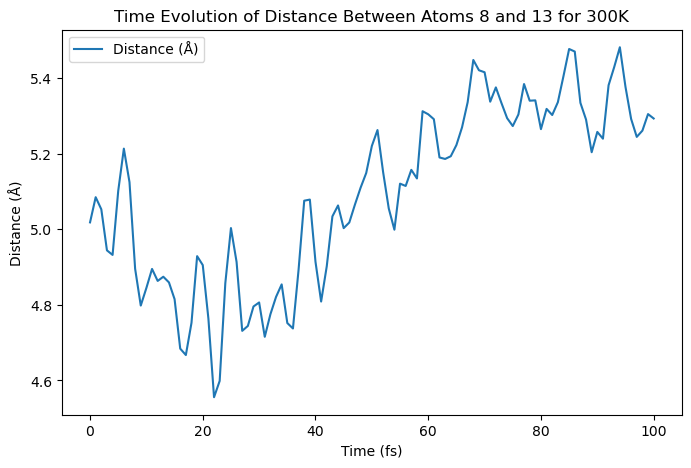

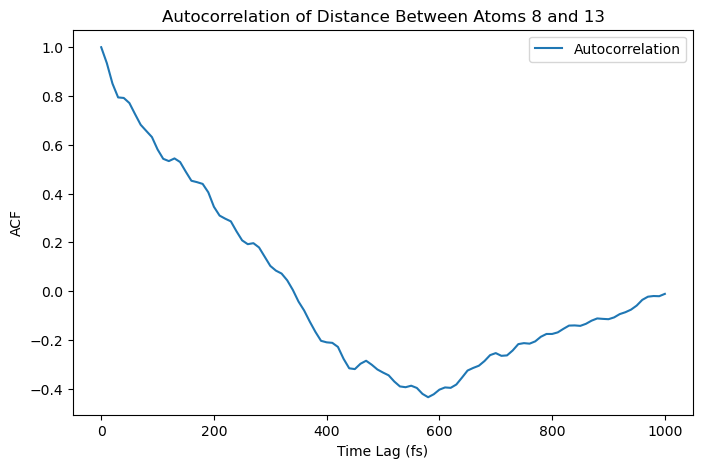

In [29]:
# ---- 📌 PLOTTING TIME EVOLUTION OF DISTANCE ----
plt.figure(figsize=(8, 5))
plt.plot(df['distance'], label="Distance (Å)")
plt.xlabel("Time (fs)")
plt.ylabel("Distance (Å)")
plt.title("Time Evolution of Distance Between Atoms 8 and 13 for 300K")
plt.legend()
plt.show()

# ---- 📌 COMPUTE AND PLOT AUTOCORRELATION FUNCTION (ACF) ----
acf_values = acf(df_300['distance'], nlags=100, fft=True)  # Compute ACF with FFT
lags = np.arange(len(acf_values)) * 10  # Convert index to time lag (fs)

plt.figure(figsize=(8, 5))
plt.plot(lags, acf_values, label="Autocorrelation")
plt.xlabel("Time Lag (fs)")
plt.ylabel("ACF")
plt.title("Autocorrelation of Distance Between Atoms 8 and 13")
plt.legend()
plt.show()

In [30]:
# --------------------------------- Initial Notes ---------------------------------
'''

We need to:
1. run molecular dynamics of isoprene
2. record the distance between atoms 8 and 13 every 10 steps 
3. plot the time evolution of this distance
4. calculate the autocorrelation function (on what)

Initial Notes

We have the code which currently:
- initialises velocity of molecules and particles
- creates the molecular dynamics object
- have a 'report' function which gets called after a certain number of steps to report
- dynamics.run(100): runs 100 steps of our molecular simulation
- dynamics.attach(report, interval = n): reports every n steps of our simulation
- .get_positions()[k,:] gets the position (in 3-dimensions) of our atoms in our molecules

- we need to investigate the acf function 


- first steps - lets run the dynamics and report every 10 time steps the distance between the two atoms

'''
# --------------------------------- Initial Code ---------------------------------


# this initialises the velocities by drawing from the appropriate distribution at T=500K
MaxwellBoltzmannDistribution(isoprene, temperature_K=500) 

# We now create a molecular dynamics object that can be used to run Langevin dynamics
# the parameters after the structure are the time step, the temperature, and the friction constant (in units of picoseconds)
dynamics = Langevin(isoprene, temperature_K=500, timestep=0.5*units.fs, friction=0.01) 

xyz_file = open('exercise_1_500K.xyz', 'w')

distance_df_500 = []
full_distance_df_500 = []

def report():

    pos_8 = isoprene.get_positions()[8,:] # retrieve position 8
    pos_13 = isoprene.get_positions()[13,:] # retrieve position 13

    distance = pos_8 - pos_13 # find distance (3 dim vector)
    scalar_distance = np.linalg.norm(distance) # norm of distance (1 dim)

    distance_df_500.append(scalar_distance) # add to list of values for plotting
    full_distance_df_500.append(distance) # add to list of values for plotting

    # maybe you don't wanna see this - looks kinda cool tho
    print("Time: {:.3f} fs  |  Potential Energy: {:.3f} eV  |  Kinetic Energy: {:.3f} K | Distance btw. atoms 8 and 13: {:.3f}".format(
        dynamics.get_time()/units.fs, isoprene.get_potential_energy(),
        isoprene.get_kinetic_energy()/(len(isoprene)*(3.0/2.0)*units.kB), 
        scalar_distance))
    
    # writes to the xyz file
    ase.io.write(xyz_file, isoprene, format="extxyz")


dynamics.attach(report, interval = 10)
dynamics.run(1000)

xyzfile.close()
del dynamics

# Convert data into Pandas DataFrame for analysis
df_500 = pd.DataFrame(full_distance_df_500, columns=['dx', 'dy', 'dz'])
df_500['distance'] = distance_df_500

Time: 0.000 fs  |  Potential Energy: -5345.999 eV  |  Kinetic Energy: 599.974 K | Distance btw. atoms 8 and 13: 4.476
Time: 5.000 fs  |  Potential Energy: -5345.943 eV  |  Kinetic Energy: 543.693 K | Distance btw. atoms 8 and 13: 4.599
Time: 10.000 fs  |  Potential Energy: -5345.843 eV  |  Kinetic Energy: 483.718 K | Distance btw. atoms 8 and 13: 4.715
Time: 15.000 fs  |  Potential Energy: -5345.948 eV  |  Kinetic Energy: 525.182 K | Distance btw. atoms 8 and 13: 4.621
Time: 20.000 fs  |  Potential Energy: -5345.787 eV  |  Kinetic Energy: 460.114 K | Distance btw. atoms 8 and 13: 4.610
Time: 25.000 fs  |  Potential Energy: -5345.505 eV  |  Kinetic Energy: 306.104 K | Distance btw. atoms 8 and 13: 4.573
Time: 30.000 fs  |  Potential Energy: -5345.999 eV  |  Kinetic Energy: 545.186 K | Distance btw. atoms 8 and 13: 4.780
Time: 35.000 fs  |  Potential Energy: -5345.972 eV  |  Kinetic Energy: 530.754 K | Distance btw. atoms 8 and 13: 4.839
Time: 40.000 fs  |  Potential Energy: -5345.847 eV

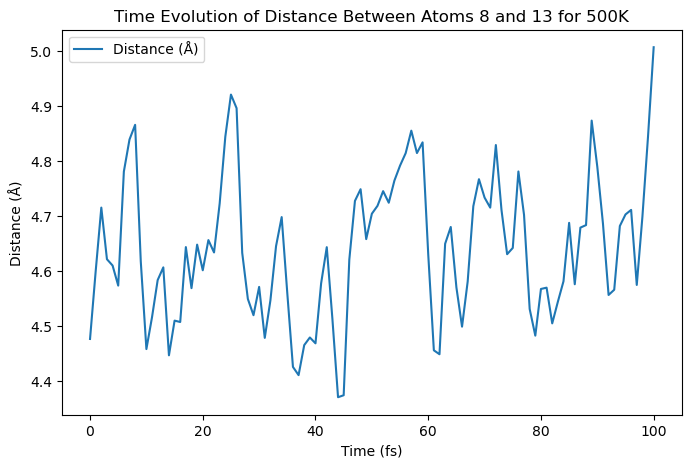

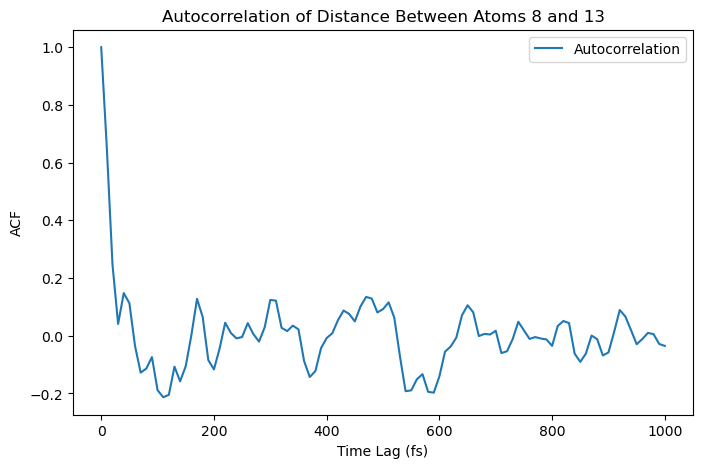

In [32]:
# ---- 📌 PLOTTING TIME EVOLUTION OF DISTANCE ----
plt.figure(figsize=(8, 5))
plt.plot(df_500['distance'], label="Distance (Å)")
plt.xlabel("Time (fs)")
plt.ylabel("Distance (Å)")
plt.title("Time Evolution of Distance Between Atoms 8 and 13 for 500K")
plt.legend()
plt.show()

# ---- 📌 COMPUTE AND PLOT AUTOCORRELATION FUNCTION (ACF) ----
acf_values = acf(df_500['distance'], nlags=100, fft=True)  # Compute ACF with FFT
lags = np.arange(len(acf_values)) * 10  # Convert index to time lag (fs)

plt.figure(figsize=(8, 5))
plt.plot(lags, acf_values, label="Autocorrelation")
plt.xlabel("Time Lag (fs)")
plt.ylabel("ACF")
plt.title("Autocorrelation of Distance Between Atoms 8 and 13 for 500K")
plt.legend()
plt.show()

### What do we find?

For 500K, we see that the autocorrelation osciallates between 0.2 and -0.2 after decreasing from 1 as we increase our time lag. We see that the distance spikes up and down around an average of around 4.6. 

For 300K CONTINUE THIS

Polyisoprene
---

In [33]:
# we now create a polyisoprene molecule
polyisoprene = pubchem_atoms_search(smiles="CC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C")
view(polyisoprene, viewer='x3d')

/Users/mac/anaconda3/lib/python3.11/site-packages/ase/data/pubchem.py:80: UserWarning: The structure "CC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C" has more than one conformer in PubChem. By default, the first conformer is returned, please ensure you are using the structure you intend to or use the `ase.data.pubchem.pubchem_conformer_search` function
  warnings.warn(


Exercise 2: fixing atoms
---
If you create a dynamics object from an atoms object that has a constraint set, the dynamics will obey that constraint. Run a short dynamics
trajectory of polyisoprene with the constraint below, and verify with Ovito that indeed the selected atoms are not moving. 

In [36]:
# we will need the ability to run molecular dynamics with constraints: the positions of two atoms at the ends of the molecule should be fixed
# the following module enables this
from ase.constraints import FixAtoms

# suppose we have identified that the atoms with indices 27 and 29 are the ones we are going to held fixed, the following
# command achieves this:
polyisoprene.set_constraint(FixAtoms(indices=[27,29]) )

polyisoprene.calc = ani.calculator


In [42]:
# ---------------  Molecular Dynamics Experiment --------

# this initialises the velocities by drawing from the appropriate distribution at T=500K
MaxwellBoltzmannDistribution(polyisoprene, temperature_K=300) 

# We now create a molecular dynamics object that can be used to run Langevin dynamics
# the parameters after the structure are the time step, the temperature, and the friction constant (in units of picoseconds)
dynamics = Langevin(polyisoprene, temperature_K=300, timestep=0.5*units.fs, friction=0.01) 

xyz_file = open('exercise_2_polyisoprene.xyz', 'w')

distance_df_atoms27and29 = []
full_distance_df_atoms27and29 = []

def report():

    pos_27 = polyisoprene.get_positions()[27,:] # retrieve position 8
    pos_29 = polyisoprene.get_positions()[29,:] # retrieve position 13

    distance = pos_27 - pos_29 # find distance (3 dim vector)
    scalar_distance = np.linalg.norm(distance) # norm of distance (1 dim)

    distance_df_atoms27and29.append(scalar_distance) # add to list of values for plotting
    full_distance_df_atoms27and29.append(distance) # add to list of values for plotting

    # maybe you don't wanna see this - looks kinda cool tho
    print("Time: {:.3f} fs  |  Potential Energy: {:.3f} eV  |  Kinetic Energy: {:.3f} K | Distance btw. atoms 27 and 29: {:.3f}".format(
        dynamics.get_time()/units.fs, polyisoprene.get_potential_energy(),
        polyisoprene.get_kinetic_energy()/(len(polyisoprene)*(3.0/2.0)*units.kB), 
        scalar_distance))
    
    # writes to the xyz file
    ase.io.write(xyz_file, polyisoprene, format="extxyz")


dynamics.attach(report, interval = 10)
dynamics.run(1000)

xyzfile.close()
del dynamics

Time: 0.000 fs  |  Potential Energy: -31915.204 eV  |  Kinetic Energy: 289.680 K | Distance btw. atoms 27 and 29: 6.369
Time: 5.000 fs  |  Potential Energy: -31914.821 eV  |  Kinetic Energy: 255.360 K | Distance btw. atoms 27 and 29: 6.369
Time: 10.000 fs  |  Potential Energy: -31915.041 eV  |  Kinetic Energy: 281.045 K | Distance btw. atoms 27 and 29: 6.369
Time: 15.000 fs  |  Potential Energy: -31914.648 eV  |  Kinetic Energy: 247.619 K | Distance btw. atoms 27 and 29: 6.369
Time: 20.000 fs  |  Potential Energy: -31914.692 eV  |  Kinetic Energy: 250.174 K | Distance btw. atoms 27 and 29: 6.369
Time: 25.000 fs  |  Potential Energy: -31914.612 eV  |  Kinetic Energy: 242.152 K | Distance btw. atoms 27 and 29: 6.369
Time: 30.000 fs  |  Potential Energy: -31914.569 eV  |  Kinetic Energy: 239.161 K | Distance btw. atoms 27 and 29: 6.369
Time: 35.000 fs  |  Potential Energy: -31914.798 eV  |  Kinetic Energy: 260.475 K | Distance btw. atoms 27 and 29: 6.369
Time: 40.000 fs  |  Potential Ener

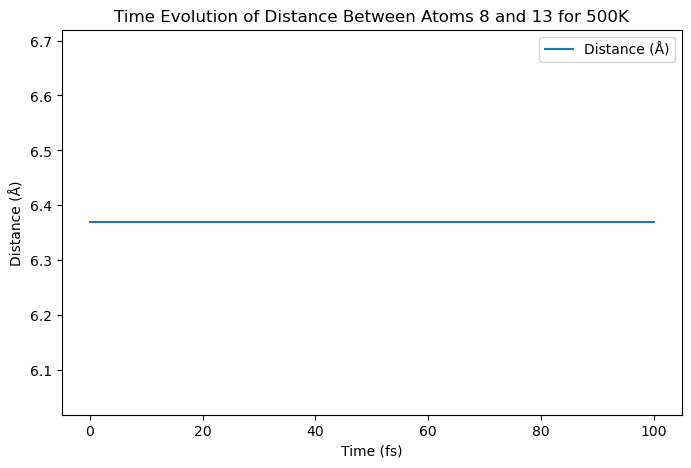

In [44]:
# ---- 📌 PLOTTING TIME EVOLUTION OF DISTANCE BETWEEN THE TWO FIXED MOLECULES ----
plt.figure(figsize=(8, 5))
plt.plot(distance_df_atoms27and29, label="Distance (Å)")
plt.xlabel("Time (fs)")
plt.ylabel("Distance (Å)")
plt.title("Time Evolution of Distance Between Atoms 8 and 13 for 500K")
plt.legend()
plt.show()

Looks pretty fixed to me lol! ❤️

Exercise 3: stretching
----

Similarly to the reporting function above, we can create a function that stretches the molecule, by simply moving one of the "fixed" atoms by a
small amount, thus increasing the distance between our "fixed" atoms. Write a function that:
- calculates the distance between the atoms,
- calculate the new position of one of the fixed atoms, so that it is slightly further away
- sets that new position for your fixed atom

You can either :

1. attach this function to the dynamics object (you can attach multiple functions to a dynamics object), and call it frequently, so the stretching is "continuous"
1. run the dynamics for a set number of steps, then call your function, and run the dynamics again for a set number of steps, etc. you can either call your stretching
function "by hand", outside the dynamics run, or attach your function to the dynamics but only have it be called very infrequently. 

Obviously, if you choose method 1 the stretch amount has to be much much smaller than in method 2 for an equivalent overall stretch rate, because it is being applied much more frequently. 
Test your setup by running a short dynamics. Initially, make the distance adjustments frequent and large (e.g. 2%) so that you can see that it is being done correctly by inspecting your short trajectory in Ovito. 

In [ ]:
# ---------------  Stretching Dynamics Experiment --------

# parameters
stretching_constant = 0.01 # a real value above 0, represents the scaling factor of the stretch
                           # e.g. stretching_constant = 0 is no stretching
                           # stretching_constant = 1 doubles the length of stretching

def stretch_func(dynamics, atom_index):

    idx1, idx2 = atom_index

    pos_idx1 = polyisoprene.get_positions()[idx1,:] # retrieve position 8
    pos_idx2 = polyisoprene.get_positions()[idx2,:] # retrieve position 13

    distance = pos_idx1 - pos_idx2 # find distance (3 dim vector)
    scalar_distance = np.linalg.norm(distance) # norm of distance (1 dim)

    
     

Main Task
---
Create a moleculary dynamics simulation in which you stretch the molecule very slowly, and measure the restoring force as a function
of displacement (I suggest using method 2 from above). 
Notes: 
- You are  interested in the force _between_ the two molecules held fixed (i.e. the force difference) and only in the component of the force along
the line connecting the two fixed atoms. 
- It is enough to record the structure every 100 steps or so, and be prepared to run the simulation for 100,000 steps or more for each fixed distance.
- I recommend that you create and record the trajectory first, and the analyse it afterwards, because the main computational cost is creating the trajectory. 
- When analysing the data, do not include data immediately after each stretch, allow the system to relax towards the equilibrium distribution for a few
thousand steps before collecting the force data.
- Calculate the autocorrelation of the restoring force value and use it to compute error bars on your measurement

In [66]:
# here is a way to read a previously recorded trajectory and computing the force between two atoms along a given direction (the example uses
# the single isoprene trajectory from an earlier exercise)
f = []
for a in ase.io.read("isoprene.xyz", index=":"):
    f.append((a.get_forces()[8,:]-a.get_forces()[13,:]) @ dru) # dru is the variable holding the unit vector between these atoms, calculated earlier
f

[0.232742628355887,
 0.9060365246513135,
 1.7297240551627888,
 2.3830171460086333,
 2.5593909972639217,
 2.5268938299882686,
 2.2939102233874356,
 1.5320556129475706,
 0.4869877300856492,
 -0.3709680501412855,
 -1.1256226542528986,
 -1.8362550453572,
 -2.3628193828940853,
 -2.715323465786733,
 -2.898703854479224,
 -2.9783705392176687,
 -2.9315361436394167,
 -2.768305978325616,
 -2.353153563698507,
 -1.8026879981881234,
 -1.0665166264412729,
 -0.34009708301300173,
 0.43745349355774166,
 1.3472192536200671,
 2.32957607068286,
 2.673220862562164,
 2.825747019432605,
 2.7785490306201264,
 2.2596324935792924,
 1.5799904290938398,
 0.9477139076113759,
 0.3051679540382948,
 -0.2164944171335476,
 -0.6404827702238757,
 -1.0222110888861622,
 -1.2601343692444305,
 -1.415402431949307,
 -1.511443787139312,
 -1.5201560069084774,
 -1.3212835882529708,
 -1.0385051606687155,
 -0.6203352549749687,
 -0.04938755893349081,
 0.5816144363776504,
 1.2313267960832672,
 1.9756764818034072,
 2.314041447064134,
 

Optional extension
---

The fact that the restoring force is entropic in origin has implications for the temperature dependence of the restoring force. Repeat the main task for
different temperature settings of the Langevin dynamics, and compare the results!